### Charger les valeurs d'accuracy construites dans un précédent script (2018-02-16_clasiffier)

In [1]:
import numpy as np
import os

path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    print('Loading accuracy...')
    accuracy =  np.load(path)
    print(accuracy)

Loading accuracy...
[[ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 ..., 
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]]


### Afficher la carte d'accuracy

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from LogGabor import LogGabor

data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=1, 
                   shuffle=True)

def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 8, 5, 2, 128, 128
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

def accuracy_128(i_offset, j_offset):
    N_pic = 128
    center = (128-55)//2
    
    accuracy_128 = accuracy[0][0] * np.ones((N_pic,N_pic))
    accuracy_128[(center+i_offset):(center+55+i_offset),(center+j_offset):(center+55+j_offset)] = accuracy
    
    accuracy_LP = phi_vector @ np.ravel(accuracy_128)
    
    image_hat = phi_plus @ accuracy_LP   
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
    fig.colorbar(cmap)
    
    return accuracy_LP

def mnist_128(i_offset, j_offset):
    N_pic = 128
    center = (128-28)//2
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data_128 = data.min() * np.ones((128,128))
        data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

        data_LP = phi_vector @ np.ravel(data_128)
        
        image_hat = phi_plus @ data_LP
        fig, ax = plt.subplots(figsize=(13, 10.725))
        cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
        fig.colorbar(cmap)
        if batch_idx == 0: break
     
    return data_LP

def couples(i_offset, j_offset):
    v = mnist_128(i_offset, j_offset)
    a = accuracy_128(i_offset, j_offset)
    
    return (v,a)

(array([ -4.86919067e-01,  -2.34905223e-01,  -1.35665740e+00,
         -7.71821489e-01,  -1.44104201e+01,  -2.98766057e+00,
          3.97590555e+00,   6.89598009e+00,   8.71416081e+00,
         -5.83016902e+00,   3.33344758e-01,  -1.44925101e+00,
          2.56474528e-01,  -4.40790161e-01,   2.80190785e+00,
         -2.74124350e+00,  -2.64362247e+00,  -3.62387918e-01,
          8.41698008e-01,   1.75466986e+01,  -1.19158151e+00,
         -1.21877719e-01,   7.48667388e-01,   1.18261898e+00,
         -2.29842829e+00,   2.16051228e+00,   1.03955878e+01,
          1.16499304e+01,   2.12592857e+01,  -1.32081227e+01,
          3.71725254e-03,   4.47732126e-01,  -5.50880419e+00,
         -1.77791473e+00,   1.55235206e+01,   3.30450792e+00,
         -2.90617343e+00,  -2.70925788e+01,  -1.29863039e+01,
         -2.26471164e+01,   5.23805550e-01,  -7.72809595e-01,
         -1.16652047e+01,  -5.33412153e+00,  -3.37889601e+01,
          3.83311082e+01,  -9.44999491e-01,  -3.75513686e+01,
        

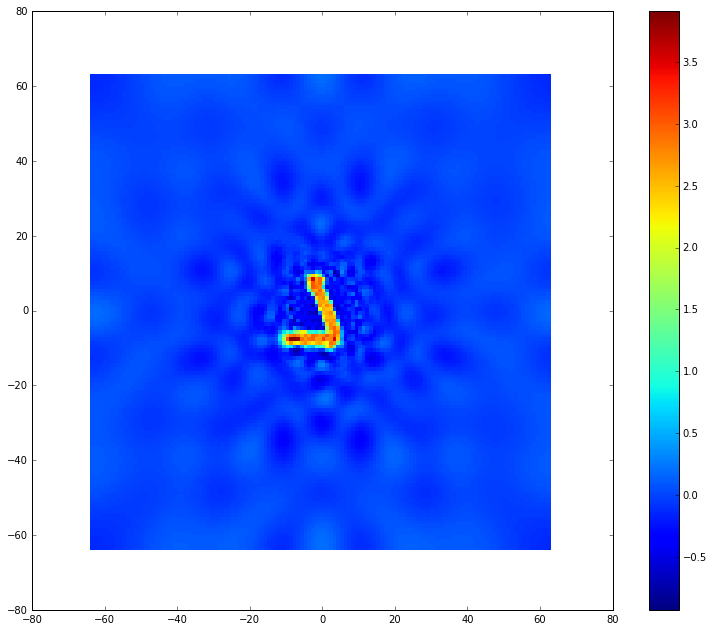

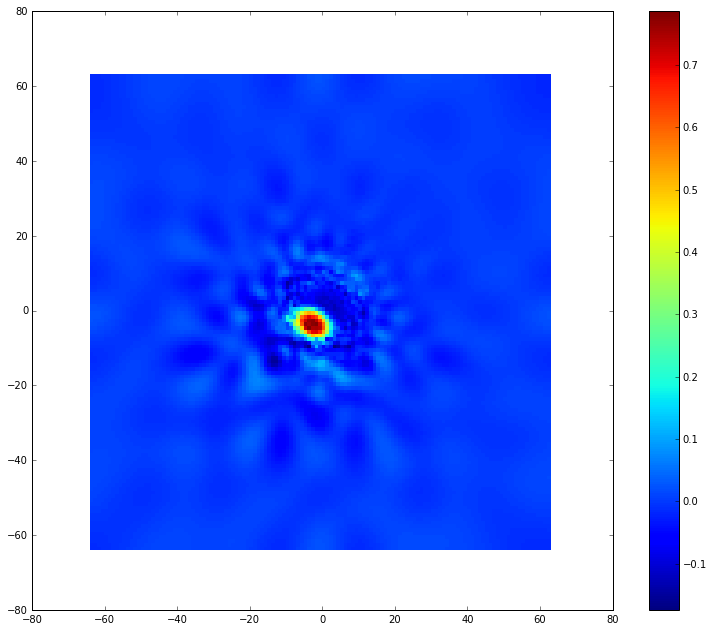

In [17]:
i_offset, j_offset = np.random.randn()*10, np.random.randn()*10 
couples(i_offset, j_offset)